## LDA for dimensionality reduction and Neural Networks 
Note: Compare to other techniques like PCA 

- First PART reduces dimensionality with an LDA
- Second part selects a Neural Network with best Hyperparameters

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [44]:
import os
import tensorflow as tf
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## LDA

In [45]:
CSVMetaData = '../datasets/ACDC_radiomics.csv'
data=pd.read_csv(CSVMetaData)

In [46]:
# Separate features and target
y = data["class"]  # Make sure this is the correct class label column
X = data.select_dtypes(include=[np.number])  # Only numeric features

# Standardize the data (mean = 0, std = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original data dimensions: {X.shape}")

Original data dimensions: (100, 644)


In [47]:
# Train-test split (recommended before LDA to evaluate performance later)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Initialize LDA: the number of components is limited to (n_classes - 1)
n_classes = len(np.unique(y))
lda = LDA(n_components=min(n_classes - 1, X.shape[1]))  # LDA max components = num_classes - 1

# Fit LDA on training data
X_lda_train = lda.fit_transform(X_train, y_train)
X_lda_test = lda.transform(X_test)

print(f"Explained variance ratio (discriminability) by LDA components: {lda.explained_variance_ratio_}")
print(f"Total variance explained by LDA: {lda.explained_variance_ratio_.sum():.2f}")

Explained variance ratio (discriminability) by LDA components: [0.59887811 0.23561906 0.11229118 0.05321165]
Total variance explained by LDA: 1.00


In [48]:
save_dir = '../datasets'
os.makedirs(save_dir, exist_ok=True)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

np.save(os.path.join(save_dir, 'X_train_lda.npy'), X_lda_train)
np.save(os.path.join(save_dir, 'X_test_lda.npy'), X_lda_test)
np.save(os.path.join(save_dir, 'y_train_lda.npy'), y_train_encoded)
np.save(os.path.join(save_dir, 'y_test_lda.npy'), y_test_encoded)

print(f"LDA features and labels saved to folder '{save_dir}'.")

LDA features and labels saved to folder '../datasets'.


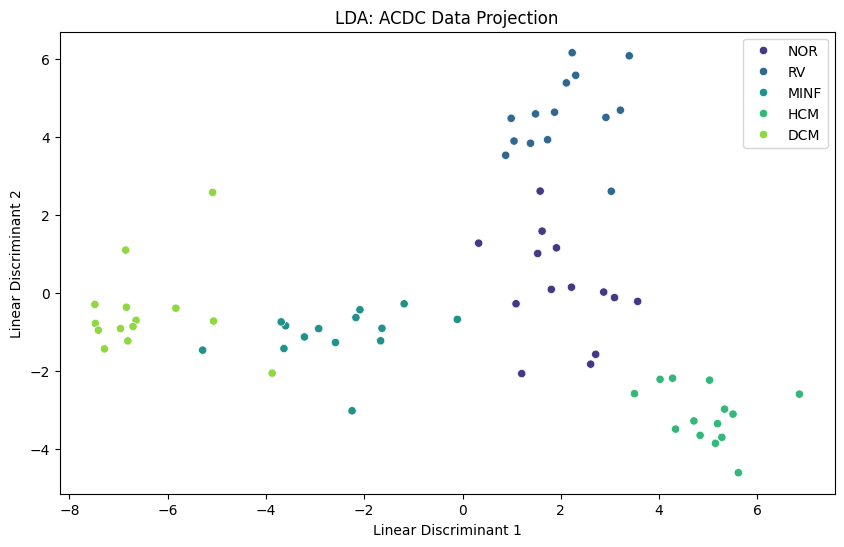

In [49]:
# Combine transformed data with labels for visualization
df_lda = pd.DataFrame(X_lda_train, columns=[f"LD{i+1}" for i in range(X_lda_train.shape[1])])
df_lda["class"] = y_train.values

# Plot first two Linear Discriminants (if at least 2 exist)
if X_lda_train.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="LD1", y="LD2", hue="class", data=df_lda, palette="viridis")
    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.title("LDA: ACDC Data Projection")
    plt.legend()
    plt.show()
else:
    print("Less than 2 LDA components, skipping 2D plot.")

## Neural Networks

In [50]:
#Call saved features
X_train_lda = np.load(os.path.join(save_dir, 'X_train_lda.npy'))
X_test_lda = np.load(os.path.join(save_dir, 'X_test_lda.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train_lda.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test_lda.npy'))

In [51]:
# Set labels
num_classes = len(np.unique(y_train))
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes)

In [52]:
# Set early stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Here we will use keras tuner:
- model builder will build  a neural network repetitively for the keras tuner
- with keras tuner we automatically find the best number of neurons, dropout rate, learning rate, etc.

In [ ]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_lda.shape[1],)))  # 4 LDA features

    # Dense layer
    hp_units = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(tf.keras.layers.Dense(hp_units, kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    #  second layer
    if hp.Boolean('add_second_layer'):
        hp_units2 = hp.Int('units_2', min_value=32, max_value=64, step=16)
        model.add(tf.keras.layers.Dense(hp_units2, kernel_initializer='he_normal'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

    # Lighter regularization 
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout))

    # Output layer
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # More careful optimizer learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [54]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='../keras_tuner_dir',
    project_name='acdc_radiomics_lda_nn'
)

Reloading Tuner from ../keras_tuner_dir\acdc_radiomics_lda_nn\tuner0.json


In [55]:
# Search
tuner.search(
    X_train_lda,
    y_train_ohe,
    epochs=60,           # Slightly longer
    batch_size=16,       # Smaller batch
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

# Best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [56]:
print("\nBest hyperparameters found:")
print(f"Units layer 1: {best_hps.get('units_1')}")
print(f"Add second layer: {best_hps.get('add_second_layer')}")
if best_hps.get('add_second_layer'):
    print(f"Units layer 2: {best_hps.get('units_2')}")
print(f"Dropout rate: {best_hps.get('dropout')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")


Best hyperparameters found:
Units layer 1: 48
Add second layer: False
Dropout rate: 0.4
Learning rate: 0.0005


In [57]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_lda,
    y_train_ohe,
    epochs=60,          # Reduced from 100 → match tuner
    batch_size=16,      # Reduced from 64 → match tuner
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Step 12: Evaluate
preds = best_model.predict(X_test_lda)
preds_labels = np.argmax(preds, axis=1)

acc = accuracy_score(y_test, preds_labels)
print(f"\nTest Accuracy of Best Model: {acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Test Accuracy of Best Model: 0.6333


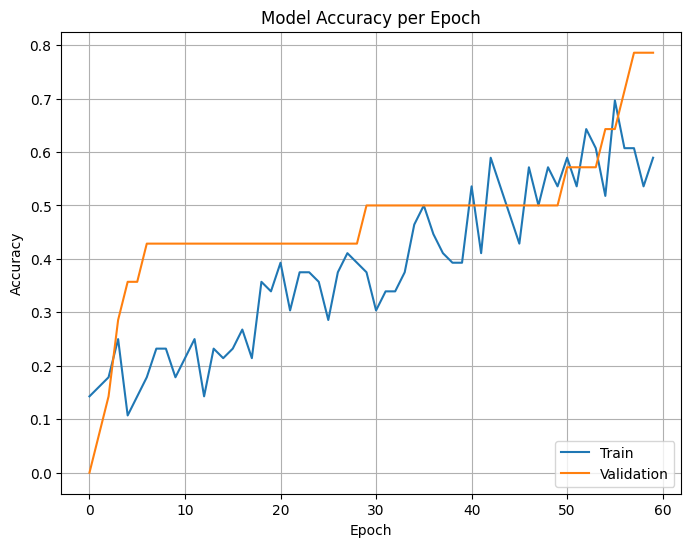

In [58]:
# Explore graphically 
# Plot training & validation accuracy values
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True)
plt.show()

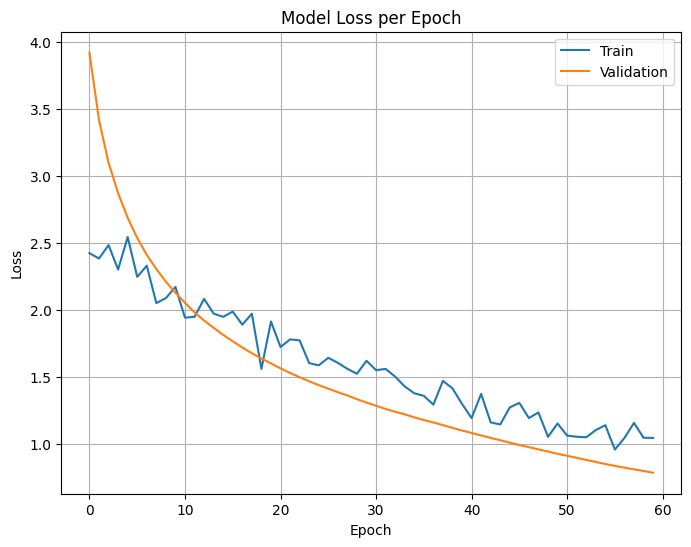

In [59]:
# Plot training & validation loss values
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


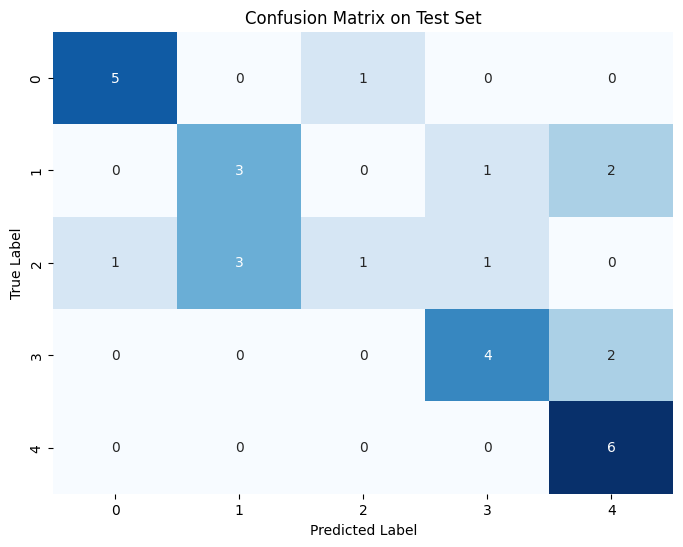

In [60]:
from sklearn.metrics import confusion_matrix
# Predict on test set
y_pred = np.argmax(best_model.predict(X_test_lda), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

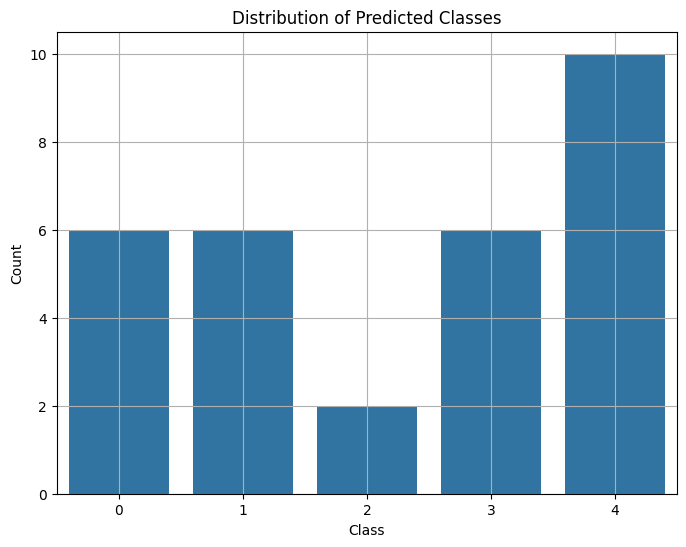

In [61]:
# Distribution of predicted classes
plt.figure(figsize=(8,6))
sns.countplot(x=y_pred)
plt.title('Distribution of Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()